In [3]:
import time 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
import os

from tqdm import tqdm
from PIL import Image
from sklearn.preprocessing import StandardScaler

import webdataset as wds
import sys

from nsd_access import NSDAccess
nsda = NSDAccess('/fsx/proj-medarc/fmri/natural-scenes-dataset/s3')

import nibabel as nib

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

sub=0
subject=f'subj0{sub+1}'
subj=subject
print(subject)

device: cuda
subj01


# Load embedding extractors

In [5]:
# CLIP
import clip
from torchvision import transforms
from models import *
clip_extractor = Clipper("ViT-L/14", device=device, hidden_state=True, norm_embs=False)
clip_extractor_last = Clipper("ViT-L/14", device=device, hidden_state=False, norm_embs=False)

# openclip_extractor = OpenClipper('ViT-H-14', device=device, hidden_state=False, norm_embs=False)
# openclip_extractor_last = OpenClipper('ViT-H-14', device=device, hidden_state=True, norm_embs=False)

# ImageBind
import sys
sys.path.insert(0, "/fsx/proj-medarc/fmri/ImageBind")
sys.path.insert(0, "/fsx/proj-medarc/fmri/ImageBind/models")
import data
import imagebind_model
from imagebind_model import ModalityType

imagebind = imagebind_model.imagebind_huge(pretrained=True)
imagebind.eval().requires_grad_(False)
imagebind.to(device)

imagebind_transform = transforms.Compose(
    [transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711))])

import copy
imagebind_hidden = copy.deepcopy(imagebind)
imagebind_hidden.modality_heads.vision = nn.Identity()
imagebind_hidden.modality_postprocessors.vision = nn.Identity()
imagebind_hidden.eval().requires_grad_(False)
imagebind_hidden.to(device)

# FCN segmentation model
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
fcn_weights = FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
fcn_model = create_feature_extractor(fcn_resnet50(weights=fcn_weights), return_nodes=["backbone.maxpool"]).to(device)
fcn_model.eval().requires_grad_(False)
pass

# Prep session-specific mean/std
This only needs to be run once; it gets loaded in the subsequent cell blocks.

In [3]:
# for sub in [0]:#,1,2,3,4,5,6,7]:
#     subject=f'subj0{sub+1}'
#     subj=subject
#     print(subject)

#     nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])-3 # 3 sessions are withheld for algonauts 
#     nsessions=nsessions_allsubj[sub];
#     ntrials = 750*nsessions
#     print(nsessions,ntrials)

#     print(time.strftime("\nCurrent time: %H:%M:%S", time.localtime())) 
    
#     lh_file = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset/{subject}/roi_masks/lh.all-vertices_fsaverage_space.npy"
#     lh_mask = np.load(lh_file)
#     rh_file = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset/{subject}/roi_masks/rh.all-vertices_fsaverage_space.npy"
#     rh_mask = np.load(rh_file)
#     mask = np.hstack((lh_mask,rh_mask))
    
#     mask = np.asarray(mask,bool)

#     # load coco 73k indices
#     indices_path = "/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_subj_indices.hdf5"
#     hdf5_file = h5py.File(indices_path, "r")
#     indices = hdf5_file[f"{subj}"][:]

#     for tar in tqdm(range(nsessions)):
#         sess=tar+1

#         # pull single-trial betas and mask them
#         betas = nsda.read_betas(subject=subject, 
#                             session_index=sess, 
#                             trial_index=[], # empty list as index means get all for this session
#                             data_type='betas_fithrf_GLMdenoise_RR',
#                             data_format='fsaverage') 

#         betas_nsd = betas[mask]
#         betas_nsd = np.moveaxis(betas_nsd,-1,0).astype('float16')
#         scalar = StandardScaler(with_mean=True, with_std=True).fit(betas_nsd) 
#         betas_nsd_mean = scalar.mean_
#         betas_nsd_std = scalar.scale_

#         np.save(f"/fsx/proj-medarc/fmri/natural-scenes-dataset/challenge_scalars/challenge_mean_sess{sess}_{subj}", betas_nsd_mean)
#         np.save(f"/fsx/proj-medarc/fmri/natural-scenes-dataset/challenge_scalars/challenge_std_sess{sess}_{subj}", betas_nsd_std)

#     print(time.strftime("\nCurrent time: %H:%M:%S", time.localtime())) 

# Create same-image repeat concatenated webdataset

In [33]:
# NOTE: you will want to parallelize this
print(time.strftime("\nCurrent time: %H:%M:%S", time.localtime())) 
total_cnt = 100

lh_file = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset/{subject}/roi_masks/lh.all-vertices_fsaverage_space.npy"
lh_mask = np.load(lh_file)
rh_file = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset/{subject}/roi_masks/rh.all-vertices_fsaverage_space.npy"
rh_mask = np.load(rh_file)
mask = np.hstack((lh_mask,rh_mask))
mask = np.asarray(mask,bool)

# load coco 73k indices
indices_path = "/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_subj_indices.hdf5"
hdf5_file = h5py.File(indices_path, "r")
indices = hdf5_file[f"{subj}"][:]

# load orig images
f = h5py.File('/fsx/proj-medarc/fmri/natural-scenes-dataset/s3/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5', 'r')
images = f['imgBrick']

# load shared 73k indices
import scipy.io as sio
nsd_design = sio.loadmat('/fsx/proj-medarc/fmri/natural-scenes-dataset/s3/nsddata/experiments/nsd/nsd_expdesign.mat')
shared_idx = nsd_design['sharedix'][0]-1
order = nsd_design['subjectim'][sub]-1

# can speed this up setting preset_cnt to $SLURM_ARRAY_TASK_ID and running total_cnt slurm jobs in parallel
# (see algo_webdataset_creation.py and slurm_wds_creation.slurm)
for preset_cnt in range(total_cnt):
    print("preset_cnt",preset_cnt)
    # for each unique image, get the betas and average
    all_betas = None
    cnt = 0; abs_cnt = 0;
    for uniq_idx in tqdm(np.unique(indices)):
        if abs_cnt==preset_cnt:
            trial_numbers = np.where(indices==uniq_idx)[0]
            for itrial, trial in enumerate(trial_numbers):
                sess = int(np.floor(trial / 750))
                sess_trial = trial - (sess * 750)
                sess += 1

                betas = nsda.read_betas(subject=subject, 
                        session_index=int(sess), 
                        trial_index=[int(sess_trial)], # empty list as index means get all for this session
                        data_type='betas_fithrf_GLMdenoise_RR',
                        data_format='fsaverage') 

                # load mean + scale to get zero mean and unit variance depending on the given session
                betas_nsd_mean = np.load(f"/fsx/proj-medarc/fmri/natural-scenes-dataset/challenge_scalars/challenge_mean_sess{sess}_{subj}.npy")
                betas_nsd_std = np.load(f"/fsx/proj-medarc/fmri/natural-scenes-dataset/challenge_scalars/challenge_std_sess{sess}_{subj}.npy")

                betas_nsd = betas[mask]
                shape = betas_nsd.shape
                betas_nsd = betas_nsd.reshape(-1,betas_nsd.shape[-2]*betas_nsd.shape[-1])  
                betas_nsd = (betas_nsd - betas_nsd_mean) / betas_nsd_std
                betas_nsd = betas_nsd.astype('float16') # (1, 15724)

                if itrial==0:
                    same_betas_nsd = betas_nsd
                else:
                    same_betas_nsd = np.concatenate((same_betas_nsd,betas_nsd),axis=0)

            if same_betas_nsd.shape[0] == 1:
                num_unique = 1
                same_betas_nsd = np.concatenate((same_betas_nsd, same_betas_nsd, same_betas_nsd), axis=0)
            elif same_betas_nsd.shape[0] == 2:
                num_unique = 2
                same_betas_nsd = np.concatenate((same_betas_nsd, np.mean(same_betas_nsd,axis=0)[None]), axis=0)
            else:
                num_unique = 3

            if all_betas is None:
                all_betas = same_betas_nsd[None]
                ordering = uniq_idx
                ordered_imgs = trial_numbers[0]
                num_uniques = num_unique
            else:
                all_betas = np.concatenate((all_betas,same_betas_nsd[None]),axis=0)
                ordering = np.append(ordering,uniq_idx)
                ordered_imgs = np.append(ordered_imgs, trial_numbers[0])
                num_uniques = np.append(num_uniques, num_unique)

        cnt += 1
        if cnt==total_cnt:
            if abs_cnt==preset_cnt: 
                sink = wds.TarWriter(f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/{subj}_{abs_cnt}.tar")
                for i,idx in enumerate(range(total_cnt*preset_cnt,total_cnt*preset_cnt+total_cnt)):
                    image = Image.fromarray(images[ordering[i]].astype('uint8').clip(0,255))
                    with torch.no_grad():
                        cur_imgs_tensor = torch.Tensor(images[ordering[i]]).permute(2,0,1).unsqueeze(0).to(device) / 255
                        ib_inputs = {ModalityType.VISION: imagebind_transform(cur_imgs_tensor)}
                        sink.write({
                            "__key__": "sample%09d" % idx,
                            "num_uniques.npy": np.array([num_uniques[i]]),
                            "coco73k.npy": np.array([ordering[i]]),
                            "vert.npy": all_betas[i],
                            "trial.npy": np.array([ordered_imgs[i]]),
                            "jpg": image,
                            "clip_emb_hidden.npy": clip_extractor.embed_image(cur_imgs_tensor).detach().cpu().numpy(),
                            "clip_emb_final.npy": clip_extractor_last.embed_image(cur_imgs_tensor).detach().cpu().numpy(),
                            "imagebind_hidden.npy": imagebind_hidden(ib_inputs)['vision'].detach().cpu().numpy(),
                            "imagebind_final.npy": imagebind(ib_inputs)['vision'].detach().cpu().numpy(),
                            "fcn_maxpool.npy": fcn_model(cur_imgs_tensor)['backbone.maxpool'].detach().cpu().numpy(),
                        })
                sink.close()

            all_betas = None
            cnt = 0
            abs_cnt += 1

    if abs_cnt==preset_cnt: # for the last batch, won't be equal to exactly total_cnt probably
        sink = wds.TarWriter(f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/{subj}_{abs_cnt}.tar")
        for i,idx in enumerate(range(total_cnt*preset_cnt,total_cnt*preset_cnt+total_cnt)):
            image = Image.fromarray(images[ordering[i]].astype('uint8').clip(0,255))
            with torch.no_grad():
                cur_imgs_tensor = torch.Tensor(images[ordering[i]]).permute(2,0,1).unsqueeze(0).to(device) / 255
                ib_inputs = {ModalityType.VISION: imagebind_transform(cur_imgs_tensor)}
                sink.write({
                    "__key__": "sample%09d" % idx,
                    "num_uniques.npy": np.array([num_uniques[i]]),
                    "coco73k.npy": np.array([ordering[i]]),
                    "vert.npy": all_betas[i],
                    "trial.npy": np.array([ordered_imgs[i]]),
                    "jpg": image,
                    "clip_emb_hidden.npy": clip_extractor.embed_image(cur_imgs_tensor).detach().cpu().numpy(),
                    "clip_emb_final.npy": clip_extractor_last.embed_image(cur_imgs_tensor).detach().cpu().numpy(),
                    "imagebind_hidden.npy": imagebind_hidden(ib_inputs)['vision'].detach().cpu().numpy(),
                    "imagebind_final.npy": imagebind(ib_inputs)['vision'].detach().cpu().numpy(),
                    "fcn_maxpool.npy": fcn_model(cur_imgs_tensor)['backbone.maxpool'].detach().cpu().numpy(),
                })
        sink.close()
    
print(time.strftime("\nCurrent time: %H:%M:%S", time.localtime())) 

# Create metadata file

In [42]:
for sub in [0]:#,1,2,3,4,5,6,7]:
    subject=f'subj0{sub+1}'
    subj=subject
    print(subject)

    metadata_path = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/metadata_{subj}.json"

    lh_file = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset/{subject}/roi_masks/lh.all-vertices_fsaverage_space.npy"
    lh_mask = np.load(lh_file)
    rh_file = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset/{subject}/roi_masks/rh.all-vertices_fsaverage_space.npy"
    rh_mask = np.load(rh_file)
    
    if sub==0:
        total_samps=(97*100)+41 # last number corresponds to the # of samples in the last .tar file
    elif sub==1:
        total_samps=0
    elif sub==2:
        total_samps=0
    elif sub==3:
        total_samps=0
    elif sub==4:
        total_samps=0
    elif sub==5:
        total_samps=0
    elif sub==6:
        total_samps=0
    elif sub==7:
        total_samps=0
    elif sub==8:
        total_samps=0
        
    print("total_samps",total_samps)
    assert total_samps>0

    # So that we have the info, let's write this to a file
    with open(metadata_path, "w") as f:    
        f.write(json.dumps({
            'total': total_samps,
            'lh_samps': str(lh_mask.sum()),
            'rh_samps': str(rh_mask.sum()),
        }, indent=4))

subj01
total_samps 9741


# Test it out

torch.Size([100, 3, 425, 425]) cpu
torch.Size([100, 3, 39548])
torch.Size([100, 1])
torch.Size([100, 1, 257, 768])


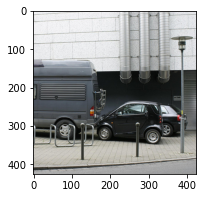

In [38]:
from utils import torch_to_Image

train_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/subj01_0.tar"
batch_size = 100

train_data = wds.WebDataset(train_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels="vert.npy", trial="trial.npy", clip="clip_emb_hidden.npy")\
    .to_tuple("voxels", "images", "trial", "clip")\
    .batched(batch_size, partial=True)

train_dl = torch.utils.data.DataLoader(train_data, num_workers=1,
                        batch_size=None, shuffle=False, persistent_workers=True)

for i, (voxel,image,trial,clip) in enumerate(train_dl):
    print(image.shape,image.device)
    print(voxel.shape)
    print(trial.shape)
    print(clip.shape)
    plt.figure(figsize=(3,3))
    plt.imshow(torch_to_Image(image))
    break

# Curating / sharding webdataset

In [ ]:
# import json
# import random
# import copy

# np.random.seed(0)
# random.seed(0)

# def add_to_set(sample, set_type):
#     writer = writers[set_type]
#     writer.write(sample)

# samples_per_shard = 500

# base_path = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds_avg_split/{subj}_{{0..98}}.tar"
# print("base_path",base_path)
# train_base_path = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds_avg_split/train/{subj}_%d.tar"
# val_base_path = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds_avg_split/val/{subj}_%d.tar"
# metadata_path = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds_avg_split/metadata_{subj}.json"

# lh_file = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset/{subject}/roi_masks/lh.all-vertices_fsaverage_space.npy"
# lh_mask = np.load(lh_file)
# rh_file = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset/{subject}/roi_masks/rh.all-vertices_fsaverage_space.npy"
# rh_mask = np.load(rh_file)

# # load coco 73k indices
# indices_path = "/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_subj_indices.hdf5"
# hdf5_file = h5py.File(indices_path, "r")
# indices = hdf5_file[f"{subj}"][:]

# # load shared 73k indices
# import scipy.io as sio
# nsd_design = sio.loadmat('/fsx/proj-medarc/fmri/natural-scenes-dataset/s3/nsddata/experiments/nsd/nsd_expdesign.mat')
# shared_idx = nsd_design['sharedix'][0]-1
# order = nsd_design['subjectim'][sub]-1

# uniq_indices = np.unique(indices)

# train_writer = wds.ShardWriter(train_base_path, maxcount=samples_per_shard, encoder=False)
# val_writer = wds.ShardWriter(val_base_path, maxcount=samples_per_shard, encoder=False)
# writers = {
#     'train': train_writer,
#     'val': val_writer,
# }

# # Iterate over the webdataset and add the sample to the appropriate set generating a new webdataset for each set
# input_webdataset = wds.WebDataset(base_path)
# vcnt = 0
# for ii, sample in enumerate(input_webdataset):
#     sample_image_id = uniq_indices[ii]
#     if vcnt<300:
#         add_to_set(sample, 'val')
#         vcnt += 1
#     else:
#         add_to_set(sample, 'train')

# print(f"Total train samples: {train_writer.total}")
# print(f"Total val samples: {val_writer.total}")

# # So that we have the info, let's write this to a file
# with open(metadata_path, "w") as f:    
#     f.write(json.dumps({
#         'train': train_writer.total,
#         'val': val_writer.total,
#         'lh_samps': str(lh_mask.sum()),
#         'rh_samps': str(rh_mask.sum()),
#     }, indent=4))

# hdf5_file.close()
# train_writer.close()
# val_writer.close()

# Upload to huggingface

In [ ]:
# from huggingface_hub import notebook_login, upload_file
# notebook_login()

In [ ]:
# from tqdm import tqdm

# for subj in [1]:#2,5,7]: # 1-indexed!

#     nshards = 20 # beware that it starts at 0, so add 1 to the max suffix
#     nshards_val = 1

#     print(f"subj0{subj}...")
#     for tar in tqdm(range(0,nshards)):
#         upload_file(
#             path_or_fileobj=f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds_avg_split/train/subj0{subj}_{tar}.tar",
#             path_in_repo=f"algonauts/train/subj0{subj}_{tar}.tar",
#             repo_id="pscotti/naturalscenesdataset",
#             repo_type="dataset")

#     for tar in tqdm(range(0,nshards_val)):
#         upload_file(path_or_fileobj=
#                     f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds_avg_split/val/subj0{subj}_{tar}.tar",
#             path_in_repo=f"algonauts/val/subj0{subj}_{tar}.tar",
#             repo_id="pscotti/naturalscenesdataset",
#             repo_type="dataset")
#     upload_file(
#     path_or_fileobj=f"/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds_avg_split/metadata_subj0{subj}.json",
#     path_in_repo=f"algonauts/metadata_subj0{subj}.json",
#     repo_id="pscotti/naturalscenesdataset",
#     repo_type="dataset")

#     print('done!')